# Sentiment Analysis Model

## 1. Imports

In [11]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import warnings
warnings.filterwarnings("ignore")

nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hadis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Hadis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## 2. Load Labelled Data

In [13]:
df = pd.read_csv("../data_02/reviews_labelled.csv")
print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (2, 1)


,version https://git-lfs.github.com/spec/v1
0,oid sha256:6c228a98eb26a28b52e75cd7137baa99625...
1,size 211589220


## 3. Exploratory Data Analysis (EDA)

sentiment_label
positive    297008
neutral     123386
negative     42350
Name: count, dtype: int64


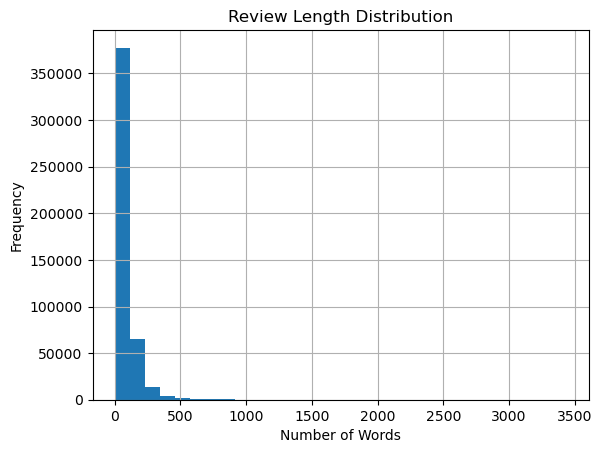

In [7]:
print(df["sentiment_label"].value_counts())
df["review_length"] = df["text"].astype(str).apply(lambda x: len(x.split()))
df["review_length"].hist(bins=30)
plt.title("Review Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

## 4. Preprocessing

In [9]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = text.strip()
    return text

def preprocess(text):
    text = clean_text(text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df["clean_text"] = df["text"].astype(str).apply(preprocess)

## 5. Encode Labels

In [11]:
le = LabelEncoder()
df["label"] = le.fit_transform(df["sentiment_label"])
print(dict(zip(le.classes_, le.transform(le.classes_))))

{'negative': 0, 'neutral': 1, 'positive': 2}


## 6. Train-Test Split

In [13]:
X = df["clean_text"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

## 7. TF-IDF Vectorization

In [15]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

## 8. Model Training and Comparison

In [17]:
from sklearn.svm import LinearSVC  # ADD THIS import at the top

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Linear SVM": LinearSVC(),
    "Random Forest": RandomForestClassifier(n_estimators=50, max_depth=20, n_jobs=-1),
    "Naive Bayes": MultinomialNB()
}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)
    print(classification_report(y_test, y_pred, target_names=le.classes_))


Training Logistic Regression...
              precision    recall  f1-score   support

    negative       0.72      0.57      0.64      8470
     neutral       0.66      0.53      0.59     24677
    positive       0.83      0.92      0.87     59402

    accuracy                           0.78     92549
   macro avg       0.74      0.67      0.70     92549
weighted avg       0.77      0.78      0.77     92549


Training Linear SVM...
              precision    recall  f1-score   support

    negative       0.73      0.56      0.63      8470
     neutral       0.68      0.51      0.58     24677
    positive       0.82      0.93      0.87     59402

    accuracy                           0.78     92549
   macro avg       0.74      0.67      0.69     92549
weighted avg       0.77      0.78      0.77     92549


Training Random Forest...
              precision    recall  f1-score   support

    negative       0.99      0.04      0.09      8470
     neutral       0.89      0.09      0.17  

## 9. Best Model Evaluation (Logistic Regression)

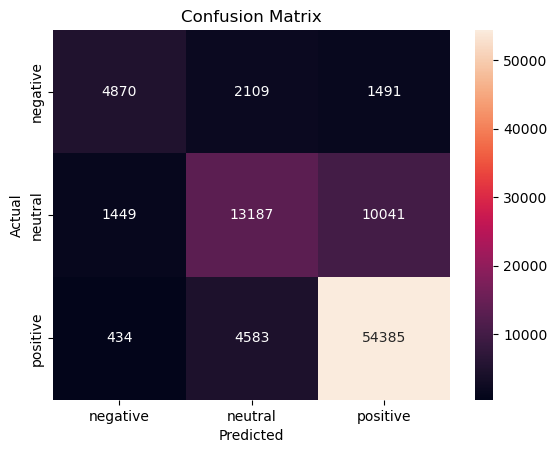

In [19]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_vec, y_train)
y_pred = clf.predict(X_test_vec)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## 10. Predict on Unlabeled Data

In [21]:
df_unlabeled = pd.read_csv("../data_02/reviews.csv")
df_unlabeled["clean_text"] = df_unlabeled["text"].astype(str).apply(preprocess)
X_unlabeled_vec = vectorizer.transform(df_unlabeled["clean_text"])

predicted_labels = clf.predict(X_unlabeled_vec)
df_unlabeled["predicted_label"] = predicted_labels
df_unlabeled["predicted_sentiment"] = le.inverse_transform(predicted_labels)

print(df_unlabeled[["user.uid", "text", "predicted_sentiment"]].head())

                     user.uid  \
0  tcdf7enqg9sxqq4ie4qh3xzjbt   
1  kszpqbggktbzmtkkkejthwyucw   
2  l01hczdvthqra6hsxbovmqipdc   
3  cmszp7l1j9pt53fvt178v3avxd   
4  bhimnczlhxddegbdaytb7gbhx2   

                                                text predicted_sentiment  
0  I have bought several of the Vitality canned d...            positive  
1  Product arrived labeled as Jumbo Salted Peanut...            negative  
2  This is a confection that has been around a fe...            positive  
3  If you are looking for the secret ingredient i...            positive  
4  Great taffy at a great price.  There was a wid...            positive  
